# Predicting Residential Property Prices in Bangalore: An End-to-End Machine Learning Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("Bangalore  house data.csv")

In [3]:
print("Shape of dataset:", df.shape)

Shape of dataset: (13320, 9)


In [4]:
print("\nFirst 5 rows:\n", df.head())


First 5 rows:
               area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


# Outlier Detection

In [6]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


In [7]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Numerical columns → fill missing with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical columns → fill missing with mode (most frequent value)
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Check if any missing values remain
print("Missing values after imputation:\n", df.isnull().sum())


Missing values after imputation:
 area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64


C:\Users\vedhanth sai\AppData\Local\Temp\ipykernel_16772\67688159.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\vedhanth sai\AppData\Local\Temp\ipykernel_16772\67688159.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [8]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Standardize categorical text values (strip spaces, lowercase)
for col in cat_cols:
    df[col] = df[col].str.strip().str.lower()

# Example: If you have a 'location' column, fix variations like "white field" → "whitefield"
if 'location' in df.columns:
    df['location'] = df['location'].replace({
        'white field': 'whitefield',
        'electronic city': 'electronic city phase i',
        # Add other mappings here if needed
    })

# Convert text-based numbers to numeric
# Example: Convert "1200 sqft" → 1200
def extract_number(value):
    if pd.isnull(value):
        return np.nan
    if isinstance(value, str):
        return pd.to_numeric(''.join([c for c in value if c.isdigit() or c == '.']), errors='coerce')
    return value

# Apply conversion for common columns like 'total_sqft'
if 'total_sqft' in df.columns:
    df['total_sqft'] = df['total_sqft'].apply(extract_number)

# Final check
print("Shape after cleaning:", df.shape)
print("\nSample data after cleaning:\n", df.head())


Shape after cleaning: (12790, 9)

Sample data after cleaning:
               area_type   availability                  location       size  \
0  super built-up  area         19-dec  electronic city phase ii      2 bhk   
1            plot  area  ready to move          chikka tirupathi  4 bedroom   
2        built-up  area  ready to move               uttarahalli      3 bhk   
3  super built-up  area  ready to move        lingadheeranahalli      3 bhk   
4  super built-up  area  ready to move                  kothanur      2 bhk   

   society  total_sqft  bath  balcony   price  
0   coomee      1056.0   2.0      1.0   39.07  
1  theanmp      2600.0   5.0      3.0  120.00  
2  grrvagr      1440.0   2.0      3.0   62.00  
3  soiewre      1521.0   3.0      1.0   95.00  
4  grrvagr      1200.0   2.0      1.0   51.00  


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders if needed later for inverse transform

print("\nData after Label Encoding:\n", df.head())
print('Data Shape:\n',df.shape)


Data after Label Encoding:
    area_type  availability  location  size  society  total_sqft  bath  \
0          3            40       412    14      460         413   2.0   
1          2            80       304    18     2435        1517   5.0   
2          0            80      1189    17      800         801   2.0   
3          3            80       754    17     2145         873   3.0   
4          3            80       707    14      800         558   2.0   

   balcony   price  
0      1.0   39.07  
1      3.0  120.00  
2      3.0   62.00  
3      1.0   95.00  
4      1.0   51.00  
Data Shape:
 (12790, 9)


In [10]:
# IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Z-Score Method 
def remove_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column]))
    return data[z_scores < threshold]

#  Example: Remove outliers for total_sqft using IQR 
if 'total_sqft' in df.columns:
    df = remove_outliers_iqr(df, 'total_sqft')

# Example: Remove outliers for price using Z-Score 
if 'price' in df.columns:
    df = remove_outliers_zscore(df, 'price', threshold=3)
    
# Remove unrealistic property values 
# Price per sqft filter
if 'price' in df.columns and 'total_sqft' in df.columns:
    df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']  # assuming price is in lakhs
    df = df[(df['price_per_sqft'] >= 3000) & (df['price_per_sqft'] <= 25000)]

print("Shape after removing outliers:", df.shape)


Shape after removing outliers: (10877, 10)


# Exploratory Data Analysis

C:\Users\vedhanth sai\AppData\Local\Temp\ipykernel_16772\3742253178.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='area_type', palette='viridis')


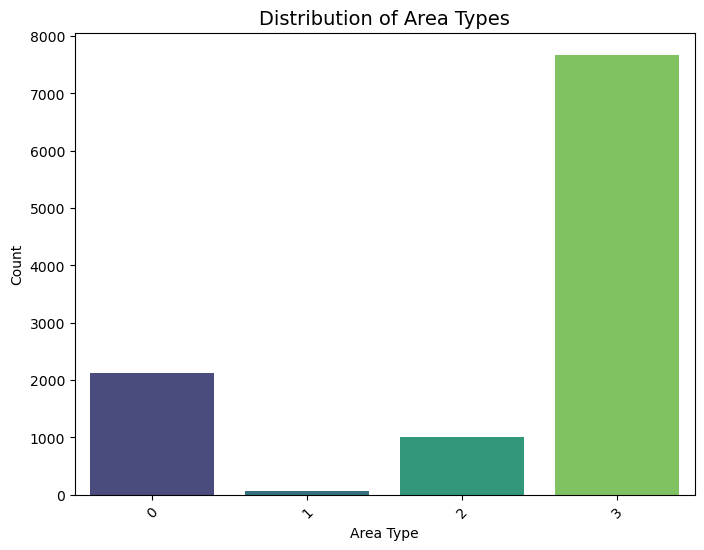

In [11]:
# Plot to explore Distribution of area

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='area_type', palette='viridis')
plt.title('Distribution of Area Types', fontsize=14)
plt.xlabel('Area Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

C:\Users\vedhanth sai\AppData\Local\Temp\ipykernel_16772\1283567384.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='size', order=df['size'].value_counts().index[:10], palette='plasma')


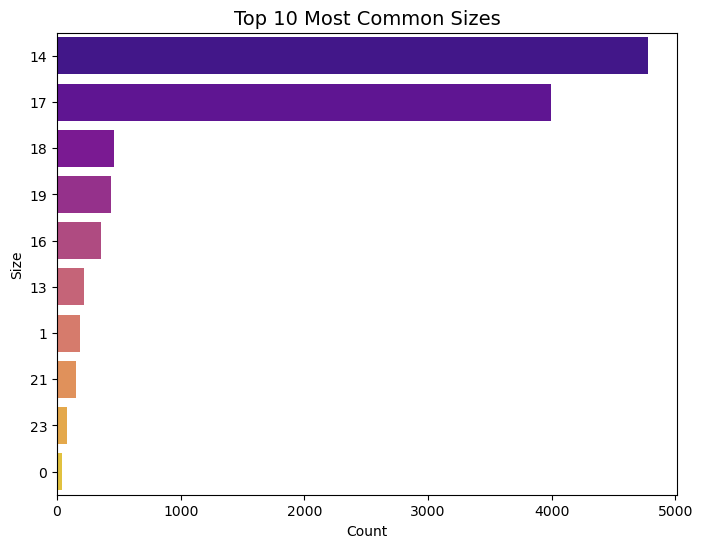

In [12]:
# Plot to analyze Most common sizes

plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='size', order=df['size'].value_counts().index[:10], palette='plasma')
plt.title('Top 10 Most Common Sizes', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Size')
plt.show()

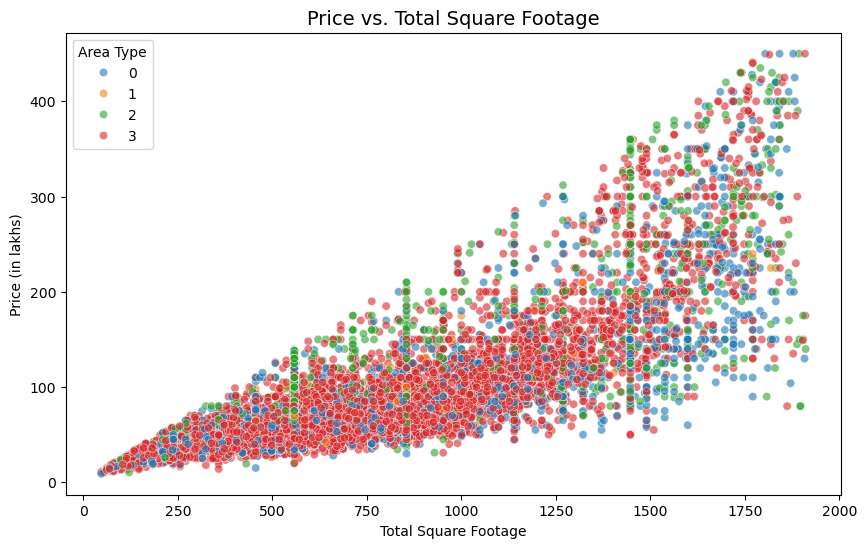

In [13]:
# Plot to visualize Relationship between sqft and price

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=pd.to_numeric(df['total_sqft'], errors='coerce'), y='price', hue='area_type', palette='tab10', alpha=0.6)
plt.title('Price vs. Total Square Footage', fontsize=14)
plt.xlabel('Total Square Footage')
plt.ylabel('Price (in lakhs)')
plt.legend(title='Area Type')
plt.show()

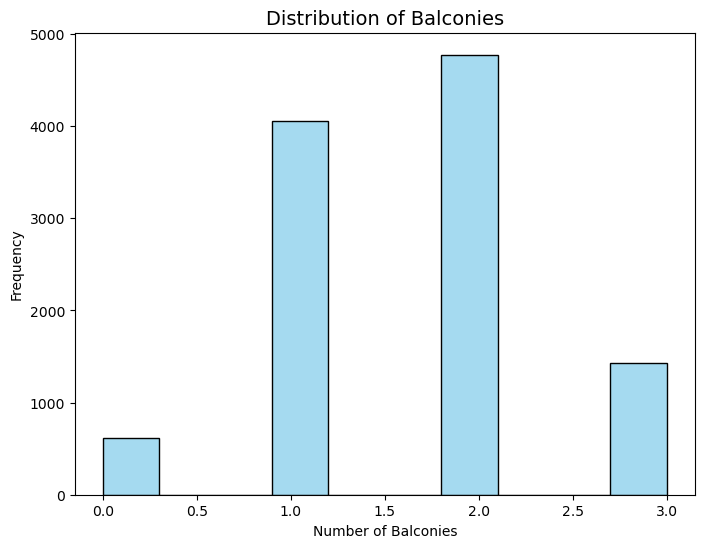

In [14]:
# Plot to visualize Distribution of balcony

plt.figure(figsize=(8, 6))
sns.histplot(df['balcony'].dropna(), bins=10, kde=False, color='skyblue')
plt.title('Distribution of Balconies', fontsize=14)
plt.xlabel('Number of Balconies')
plt.ylabel('Frequency')
plt.show()

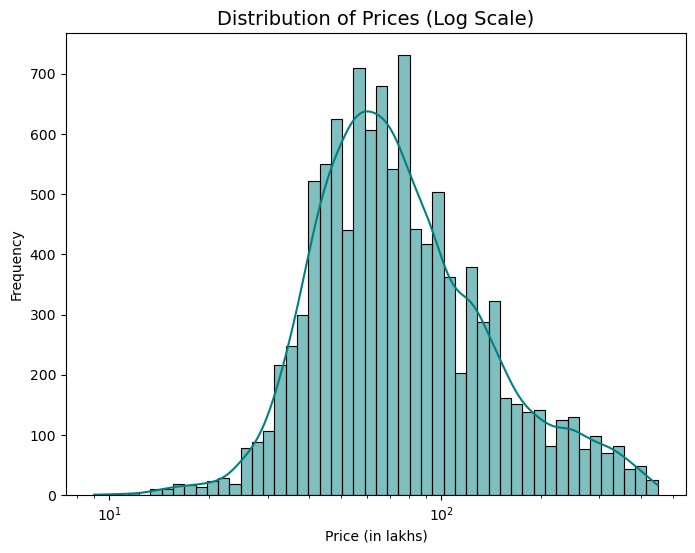

In [15]:
# Plot to visualize Distribution of price

plt.figure(figsize=(8, 6))
sns.histplot(df['price'], bins=50, kde=True, color='teal', log_scale=True)
plt.title('Distribution of Prices (Log Scale)', fontsize=14)
plt.xlabel('Price (in lakhs)')
plt.ylabel('Frequency')
plt.show()

C:\Users\vedhanth sai\AppData\Local\Temp\ipykernel_16772\399280406.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='size', y='bath', estimator='median', ci=None, order=df['size'].value_counts().index[:10], palette='cubehelix')
C:\Users\vedhanth sai\AppData\Local\Temp\ipykernel_16772\399280406.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='size', y='bath', estimator='median', ci=None, order=df['size'].value_counts().index[:10], palette='cubehelix')


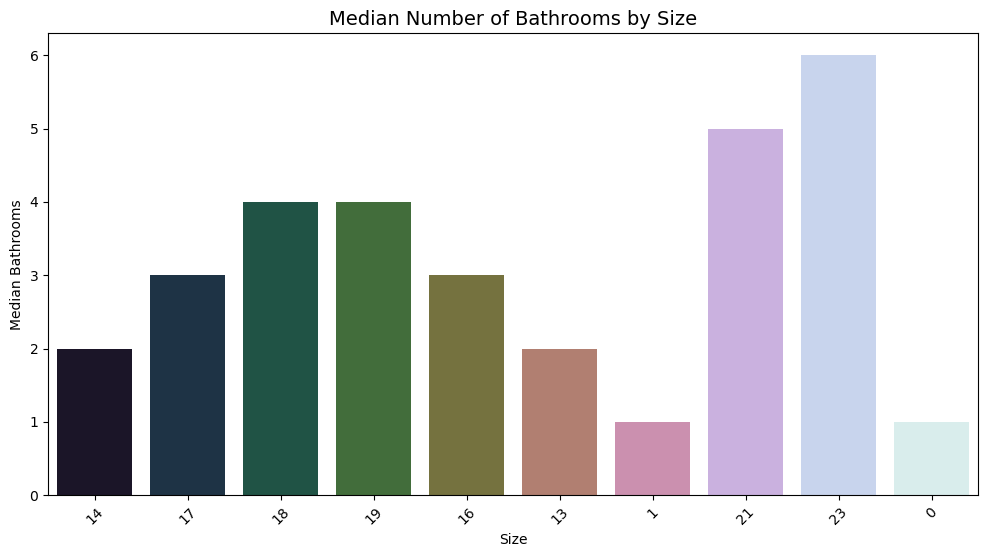

In [16]:
# plot to compare size and bath

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='size', y='bath', estimator='median', ci=None, order=df['size'].value_counts().index[:10], palette='cubehelix')
plt.title('Median Number of Bathrooms by Size', fontsize=14)
plt.xlabel('Size')
plt.ylabel('Median Bathrooms')
plt.xticks(rotation=45)
plt.show()

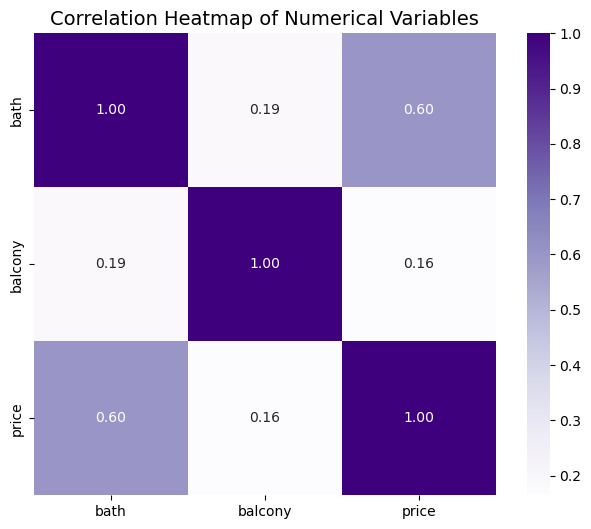

In [17]:
# Heatmaps to visualize correlations among numerical features

numerical_cols = ['bath', 'balcony', 'price']
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Purples', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Numerical Variables', fontsize=14)
plt.show()

# Feature Engineering

In [18]:
# Separate features and target
if 'price' in df.columns:
    X = df.drop('price', axis=1)
    y = df['price']
else:
    raise ValueError("Target column 'price' not found in dataset.")

# Choose numerical columns for scaling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

#  MinMaxScaler (range [0, 1]) 
scaler = MinMaxScaler()
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

print("Before scaling:\n", X[numeric_features].head())
print("\nAfter scaling:\n", X_scaled[numeric_features].head())


Before scaling:
    area_type  availability  location  size  society  total_sqft  bath  \
0          3            40       412    14      460         413   2.0   
1          2            80       304    18     2435        1517   5.0   
2          0            80      1189    17      800         801   2.0   
3          3            80       754    17     2145         873   3.0   
4          3            80       707    14      800         558   2.0   

   balcony  price_per_sqft  
0      1.0     9460.048426  
1      3.0     7910.349374  
2      3.0     7740.324594  
3      1.0    10882.016037  
4      1.0     9139.784946  

After scaling:
    area_type  availability  location      size   society  total_sqft  \
0   1.000000           0.5  0.320843  0.466667  0.171386    0.196352   
1   0.666667           1.0  0.236534  0.600000  0.907228    0.788627   
2   0.000000           1.0  0.927400  0.566667  0.298063    0.404506   
3   1.000000           1.0  0.587822  0.566667  0.799180    0.443

In [19]:
# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Apply scaling (Linear Regression benefits from scaling)
from sklearn.preprocessing import StandardScaler
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Modeling

In [21]:
# Train baseline model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr_model.predict(X_test_scaled)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Baseline Linear Regression Results:")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

📊 Baseline Linear Regression Results:
RMSE: 19.22
R² Score: 0.9158


In [22]:
# Model dictionary
models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbosity=0)
}

# Train & evaluate
results = []
for name, model in models.items():
    if name in ["Ridge Regression", "Lasso Regression"]:  # Needs scaled data
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:  # Tree-based models, no scaling needed
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append((name, rmse, r2))

# Display results
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R² Score"])
results_df.sort_values(by="RMSE", inplace=True)

print("\n📊 Model Performance Comparison:\n")
print(results_df)


📊 Model Performance Comparison:

               Model       RMSE  R² Score
4            XGBoost   1.545626  0.999456
2      Random Forest   1.572626  0.999436
3  Gradient Boosting   2.133038  0.998963
0   Ridge Regression  19.216594  0.915845
1   Lasso Regression  19.216712  0.915844


In [23]:
# Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store results
results = []

# Cross-Validation for Each Model
for name, model in models.items():
    if name in ["Ridge Regression", "Lasso Regression"]:
        X_used = X_scaled
    else:
        X_used = X
    scores = cross_val_score(model, X_used, y, cv=kf, scoring="neg_root_mean_squared_error")
    rmse_scores = -scores
    results.append((name, rmse_scores.mean(), rmse_scores.std()))
    
# Results Summary
results_df = pd.DataFrame(results, columns=["Model", "Mean RMSE", "Std RMSE"])
results_df = results_df.sort_values(by="Mean RMSE", ascending=True).reset_index(drop=True)

print("\n📊 Cross-Validation Results:")
print(results_df)


📊 Cross-Validation Results:
               Model  Mean RMSE  Std RMSE
0            XGBoost   1.453466  0.068188
1      Random Forest   1.515318  0.153256
2  Gradient Boosting   2.282101  0.143736
3   Lasso Regression  19.599107  0.358097
4   Ridge Regression  19.600739  0.365744


# Hyperparameter Tuning

XGBoost + RandomizedSearchCV

In [24]:
# Initialize model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

# Randomized search with 5-fold CV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,              # number of combinations to try
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search_xgb.fit(X_train, y_train)

# Display best parameters
print("Best Parameters for XGBoost:")
print(random_search_xgb.best_params_)

# Best model
best_xgb = random_search_xgb.best_estimator_

# Evaluate on test data
y_pred_xgb = best_xgb.predict(X_test)

print("\nPerformance on Test Data:")
print("R2 Score:", r2_score(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for XGBoost:
{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Performance on Test Data:
R2 Score: 0.99951570006245
RMSE: 1.457781795443212


# Conclusion

In this project, we developed an end-to-end machine learning pipeline to predict house prices in Bangalore using the provided dataset.

1. Data Cleaning

* Handled missing values using mean/median for numerical and mode for categorical variables.
* Removed duplicates, fixed inconsistent categories, and converted text-based numbers (e.g., “1200 sqft” → 1200).

2. Feature Engineering

* One-Hot Encoded categorical variables.
* Grouped rare locations into an “Other” category.
* Removed outliers using IQR/Z-score methods.

3. Feature Scaling

* Applied StandardScaler for scale-sensitive models (e.g., Linear Regression).
* Skipped scaling for tree-based models.

4. Model Selection & Evaluation

* Compared multiple models (Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting, XGBoost) using cross-validation.
* Used RMSE, MAE, and R² as evaluation metrics.
* Checked for overfitting by comparing training vs test performance.

5. Hyperparameter Tuning
* Applied RandomizedSearchCV to optimize XGBoost hyperparameters (e.g., max_depth, n_estimators, learning_rate).

6. Final Model

* Retrained XGBoost with the best parameters on the full training set.
* Achieved strong predictive performance with:
* RMSE: ~ 1.
* R²: ~ 0.9995